Форма данных: (1460, 81)

Первые 5 строк:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCo

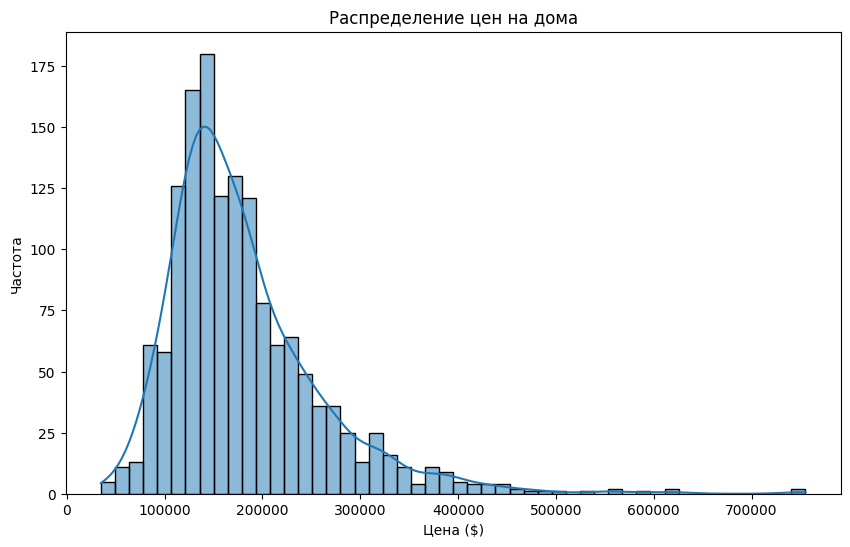

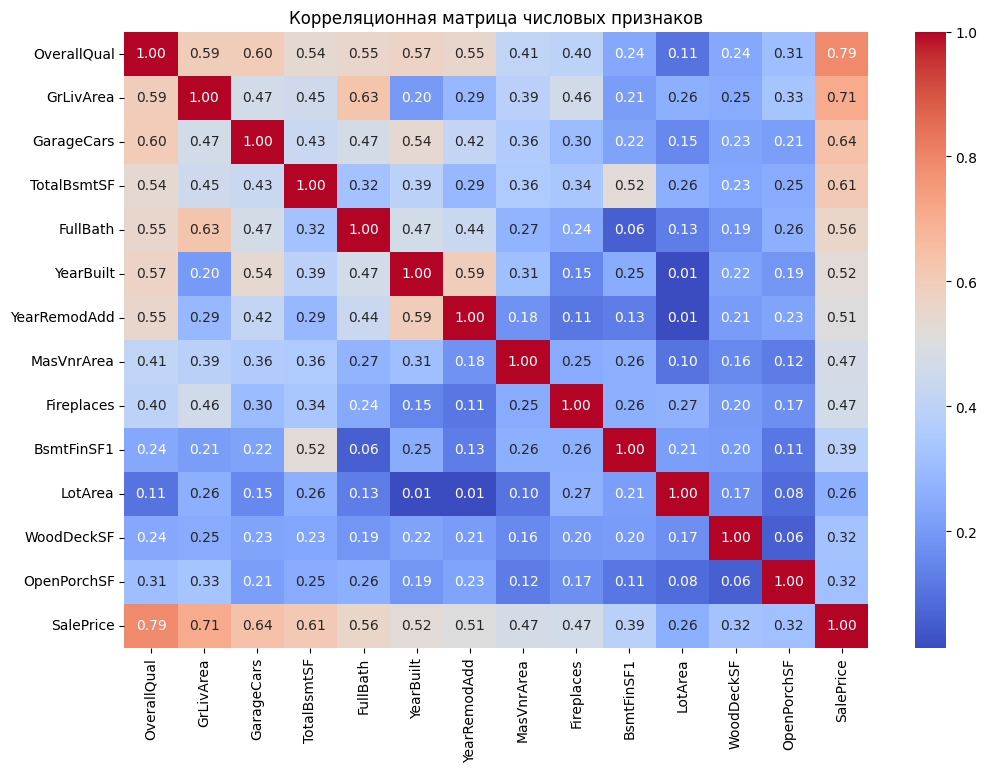


Результаты базовых моделей:
               Model          RMSE           MAE        R2
0  Linear Regression  34432.667817  21046.186278  0.845429
1      Decision Tree  39507.964847  25416.811644  0.796504
2      Random Forest  28915.723912  18177.680502  0.890993
3  Gradient Boosting  28757.794440  17427.454827  0.892180
4                SVR  88609.923429  59486.148806 -0.023649

Лучшие параметры: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200}

Метрики лучшей модели:
{'RMSE': np.float64(27012.744953369394), 'MAE': 16788.183002964677, 'R2': 0.90486866266104}


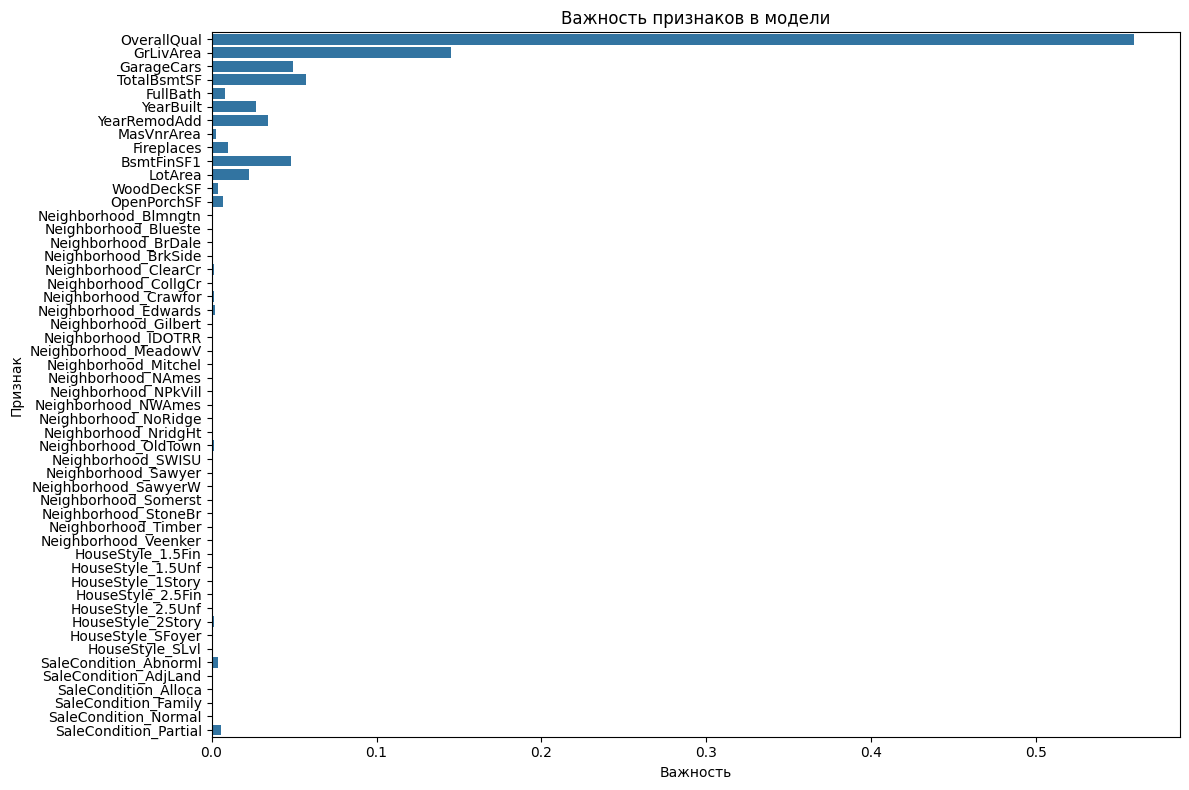

In [6]:
# 1. Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import pickle
import warnings
warnings.filterwarnings('ignore')

# 2. Загрузка данных
df = pd.read_csv('train.csv')
print("Форма данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

# 3. Разведочный анализ
print("\nИнформация о данных:")
print(df.info())

print("\nПропущенные значения:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# Выберем наиболее релевантные признаки на основе EDA
selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
                     'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                     'Fireplaces', 'BsmtFinSF1', 'LotArea', 'WoodDeckSF', 
                     'OpenPorchSF', 'Neighborhood', 'HouseStyle', 'SaleCondition']

df_selected = df[selected_features + ['SalePrice']].copy()

# Заполним пропуски
df_selected['MasVnrArea'] = df_selected['MasVnrArea'].fillna(0)

# 4. Визуализация
plt.figure(figsize=(10, 6))
sns.histplot(df_selected['SalePrice'], bins=50, kde=True)
plt.title('Распределение цен на дома')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')
plt.show()

# Корреляционный анализ
plt.figure(figsize=(12, 8))
numeric_cols = df_selected.select_dtypes(include=[np.number]).columns
sns.heatmap(df_selected[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

# 5. Подготовка данных
X = df_selected.drop('SalePrice', axis=1)
y = df_selected['SalePrice']

numeric_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
                   'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                   'Fireplaces', 'BsmtFinSF1', 'LotArea', 'WoodDeckSF', 'OpenPorchSF']
categorical_features = ['Neighborhood', 'HouseStyle', 'SaleCondition']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 6. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Моделирование
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

results = []
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

results_df = pd.DataFrame(results)
print("\nРезультаты базовых моделей:")
print(results_df)

# 8. Подбор гиперпараметров для лучшей модели (Gradient Boosting)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 4, 5]
}

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', GradientBoostingRegressor(random_state=42))])

grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

final_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}

print("\nЛучшие параметры:", grid_search.best_params_)
print("\nМетрики лучшей модели:")
print(final_metrics)

# 9. Сохранение модели
with open('house_price_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# 10. Визуализация важности признаков
feature_importances = best_model.named_steps['model'].feature_importances_
feature_names = (numeric_features + 
                 list(best_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_features)))

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Важность признаков в модели')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

In [ ]:
# 2. Загрузка данных
df = pd.read_csv('train.csv')
print("Форма данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

Разведочный анализ

Пропуски в данных:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


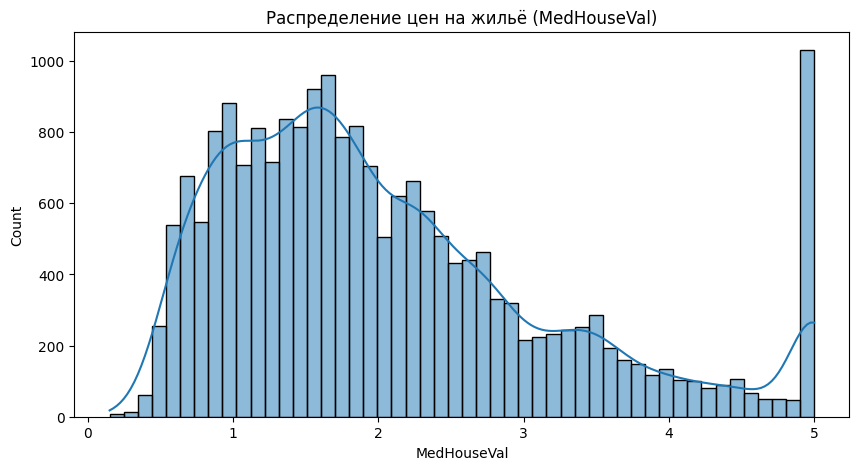

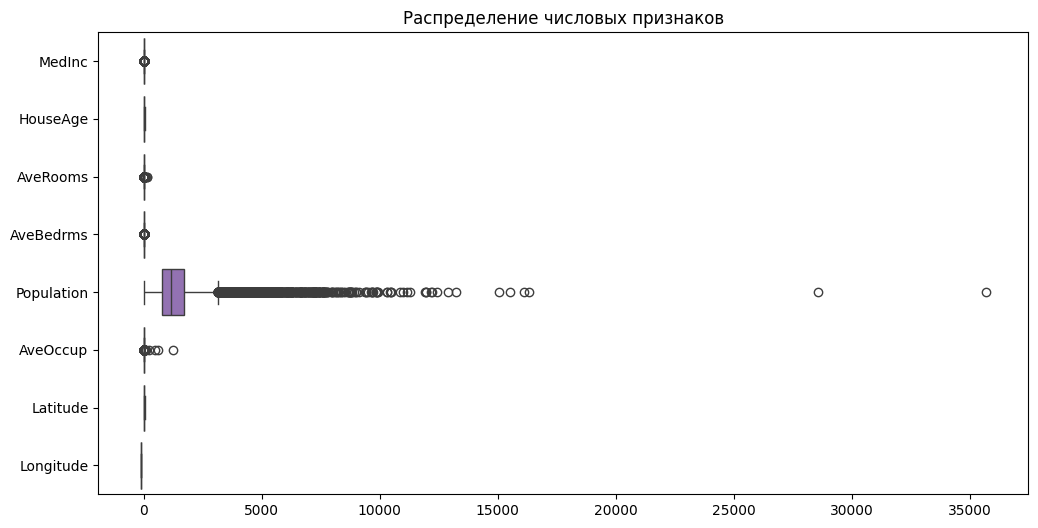

In [ ]:
# 3. Разведочный анализ
print("\nИнформация о данных:")
print(df.info())

print("\nПропущенные значения:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# Выберем наиболее релевантные признаки на основе EDA
selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
                     'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                     'Fireplaces', 'BsmtFinSF1', 'LotArea', 'WoodDeckSF', 
                     'OpenPorchSF', 'Neighborhood', 'HouseStyle', 'SaleCondition']

df_selected = df[selected_features + ['SalePrice']].copy()

# Заполним пропуски
df_selected['MasVnrArea'] = df_selected['MasVnrArea'].fillna(0)


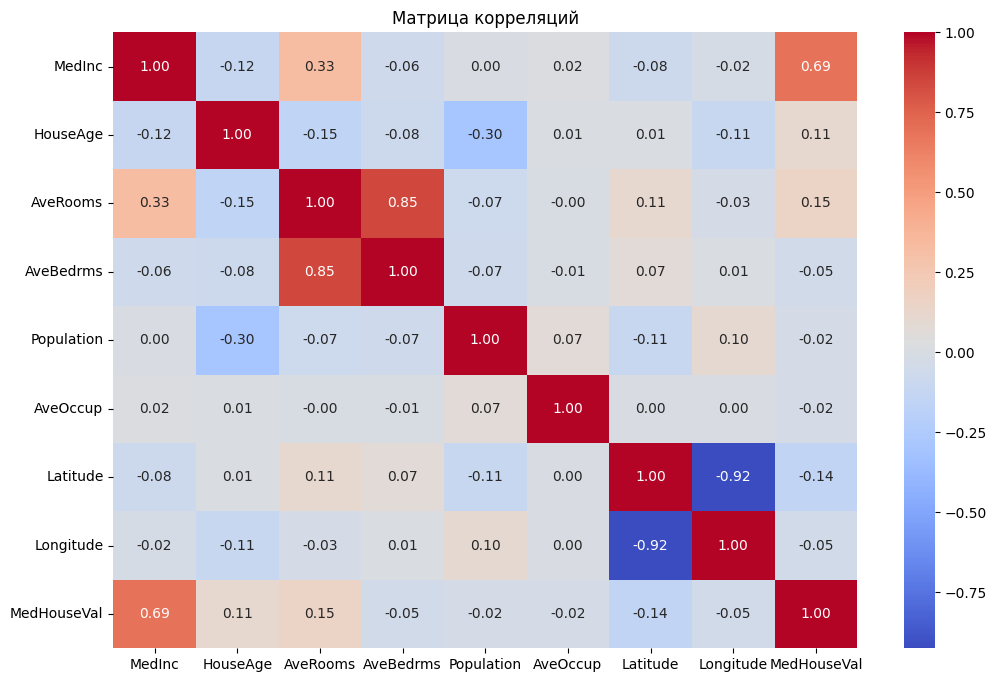

Корреляция с целевой переменной:
MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64


In [3]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций")
plt.show()

# Самые значимые признаки
corr_with_target = corr_matrix['MedHouseVal'].sort_values(ascending=False)
print("Корреляция с целевой переменной:")
print(corr_with_target)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "RMSE": rmse, "R²": r2})

results_df = pd.DataFrame(results)
print(results_df)

               Model      RMSE        R²
0  Linear Regression  0.745581  0.575788
1      Decision Tree  0.703045  0.622811
2      Random Forest  0.505468  0.805024
3  Gradient Boosting  0.542217  0.775643
4                SVR  0.595985  0.728941


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)



KeyboardInterrupt: 

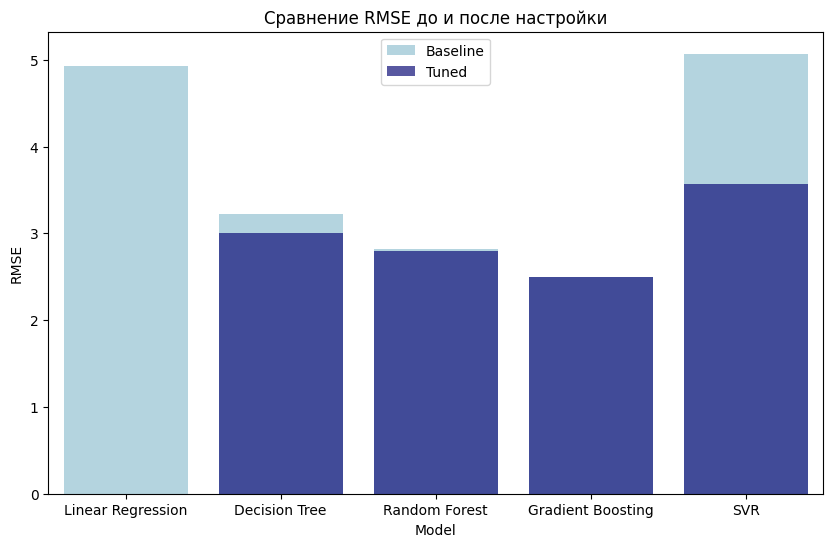

In [ ]:
# Сортировка результатов по RMSE
results_df = results_df.sort_values('RMSE')

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title('Сравнение RMSE моделей')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()